In [1]:
import psycopg2
import pandas as pd
import pandas.io.sql as sqlio
from config import database, user, password, host, port
import numpy as np
con = psycopg2.connect(database=database, user=user, password=password, host=host, port=port)
sql = "SELECT * FROM Players;"
all_df = sqlio.read_sql_query(sql, con)
con = None

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Postgresql DB connection 
    we will display the dataframe now that we have connected to the postgresql with our notebook and we will display it through pandas.

In [3]:
all_df.head()


,name,age,year,team,league,player_salary,percent_season_played,war_psp,num_dl_movements,team_win_percentage,team_payroll,percent_contract_complete
0,Bobby Abreu,26,2000,PHI,NL,4354977,0.994676,6.213081,0,0.401235,69700927,33.333332
1,Bobby Abreu,27,2001,PHI,NL,7193330,1.029782,5.039903,0,0.530864,60144837,66.666664
2,Bobby Abreu,28,2002,PHI,NL,9000338,1.001989,5.818425,0,0.493827,82364470,100.000000
3,Bobby Abreu,29,2003,PHI,NL,12643905,1.016617,5.282226,0,0.530864,98344579,16.666668
4,Bobby Abreu,30,2004,PHI,NL,14346025,1.042947,6.289872,0,0.530864,126162692,33.333332


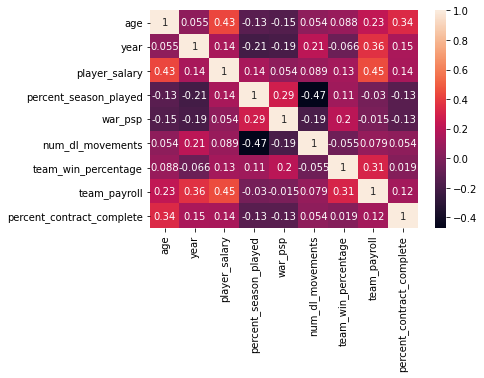

In [4]:
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = all_df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

#### Columns and Target Variable
    We will create a list of the columns that are useful for our data as well as pick our target column - which is the WAR (Wins above Replacement) since that is our predictor variable.

In [5]:
columns = ["name", "age", "year", "team", "division", "league", "player_salary", "percent_season_played", "num_dl_movements", "team_win_percentage", 
           "team_payroll", "percent_contract_complete"]
          

target = ["war_psp"]


##### Variables to encode: team & league

    Loading in the data and cleaning it will be the next steps in this analysis. 

    We are first going to encode the categorical variables team and league in order to use them in our regression analysis.

    This will allow us to separate the data into testing and training sets. This is a resampling method. 

In [6]:
league_binary_encoded = pd.get_dummies(all_df, columns=["league"])
league_binary_encoded.head()

,name,age,year,team,player_salary,percent_season_played,war_psp,num_dl_movements,team_win_percentage,team_payroll,percent_contract_complete,league_AL,league_AL/NL,league_NL,league_NL/AL,league_NL/AL/AL,league_NL/AL/NL
0,Bobby Abreu,26,2000,PHI,4354977,0.994676,6.213081,0,0.401235,69700927,33.333332,0,0,1,0,0,0
1,Bobby Abreu,27,2001,PHI,7193330,1.029782,5.039903,0,0.530864,60144837,66.666664,0,0,1,0,0,0
2,Bobby Abreu,28,2002,PHI,9000338,1.001989,5.818425,0,0.493827,82364470,100.000000,0,0,1,0,0,0
3,Bobby Abreu,29,2003,PHI,12643905,1.016617,5.282226,0,0.530864,98344579,16.666668,0,0,1,0,0,0
4,Bobby Abreu,30,2004,PHI,14346025,1.042947,6.289872,0,0.530864,126162692,33.333332,0,0,1,0,0,0


In [7]:
league_binary_encoded.loc[(league_binary_encoded["league_NL/AL/NL"] == 1)]

,name,age,year,team,player_salary,percent_season_played,war_psp,num_dl_movements,team_win_percentage,team_payroll,percent_contract_complete,league_AL,league_AL/NL,league_NL,league_NL/AL,league_NL/AL/AL,league_NL/AL/NL
320,David DeJesus,33,2013,CHC/TBR/WSN,4664132,0.642151,2.958806,1,0.502058,100091461,66.666664,0,0,0,0,0,1


In [8]:
league_binary_encoded.loc[(league_binary_encoded["league_NL/AL/AL"] == 1)]

,name,age,year,team,player_salary,percent_season_played,war_psp,num_dl_movements,team_win_percentage,team_payroll,percent_contract_complete,league_AL,league_AL/NL,league_NL,league_NL/AL,league_NL/AL/AL,league_NL/AL/NL
1731,Jaime Garcia,30,2017,ATL/MIN/NYY,12515845,0.839572,1.465032,0,0.510288,142025719,100.0,0,0,0,0,1,0


    These two players are the only ones that have been traded 2 times within a single season over the last 25 season, therefore there is not a significance for keeping these two players in our dataset. Removing two players' data is not going to change our results significantly enough due to the large sample size.

In [9]:
MLB_df = all_df.loc[(all_df["league"] != "NL/AL/NL") & (all_df["league"] != "NL/AL/AL")]


In [10]:
MLB_df.loc[(all_df["league"] == "NL/AL/AL") | (all_df["league"] == "NL/AL/NL")]

,name,age,year,team,league,player_salary,percent_season_played,war_psp,num_dl_movements,team_win_percentage,team_payroll,percent_contract_complete


In [11]:
MLB_df["league"].unique().tolist()

['NL', 'AL/NL', 'AL', 'NL/AL']

In [12]:
league_binary_encoded.loc[(league_binary_encoded["league_NL/AL"] == 1)].count()

name                         39
age                          39
year                         39
team                         39
player_salary                39
percent_season_played        39
war_psp                      39
num_dl_movements             39
team_win_percentage          39
team_payroll                 39
percent_contract_complete    39
league_AL                    39
league_AL/NL                 39
league_NL                    39
league_NL/AL                 39
league_NL/AL/AL              39
league_NL/AL/NL              39
dtype: int64

In [13]:
league_binary_encoded.loc[(league_binary_encoded["league_AL/NL"] == 1)].count()

name                         43
age                          43
year                         43
team                         43
player_salary                43
percent_season_played        43
war_psp                      43
num_dl_movements             43
team_win_percentage          43
team_payroll                 43
percent_contract_complete    43
league_AL                    43
league_AL/NL                 43
league_NL                    43
league_NL/AL                 43
league_NL/AL/AL              43
league_NL/AL/NL              43
dtype: int64

    To make the data more uniform - we are going to redefine all of the single trades in a season to be Uniform in AL/NL instead of both AL/NL and NL/AL 

In [14]:
MLB_df = MLB_df.replace(to_replace = "NL/AL", value="AL/NL", regex=True)



In [15]:
MLB_df["league"].unique().tolist()

['NL', 'AL/NL', 'AL']

    above we have shown that the new all_df we will be working with has a uniform league column now - with no NL/AL values but with replaced AL/NL values. We have also reassured the absence of the multiple trades players. 
    
    Now we will create the encoded values for the different leagues 
    
    0 -> NL
    1 -> AL
    2 -> AL/NL
    
    and convert the values to the encoded values 

In [16]:
MLB_df = MLB_df.replace({'league': {'NL': 0, 'AL': 1, 'AL/NL': 2}})
MLB_df.head()

,name,age,year,team,league,player_salary,percent_season_played,war_psp,num_dl_movements,team_win_percentage,team_payroll,percent_contract_complete
0,Bobby Abreu,26,2000,PHI,0,4354977,0.994676,6.213081,0,0.401235,69700927,33.333332
1,Bobby Abreu,27,2001,PHI,0,7193330,1.029782,5.039903,0,0.530864,60144837,66.666664
2,Bobby Abreu,28,2002,PHI,0,9000338,1.001989,5.818425,0,0.493827,82364470,100.000000
3,Bobby Abreu,29,2003,PHI,0,12643905,1.016617,5.282226,0,0.530864,98344579,16.666668
4,Bobby Abreu,30,2004,PHI,0,14346025,1.042947,6.289872,0,0.530864,126162692,33.333332


    Now we are going to view the different team names in this dataset:

In [17]:
team_names = MLB_df["team"].unique().tolist()
len(team_names)

167

    there are 167 unique team names / trades in our current dataframe
    
    from here we need to either encode the values or determine if the team name plays a imperative role in our analysis.

In [18]:
team_names_dict = {team_names[i]: i for i in range(len(team_names))}

    from the team_names_dict we will conver the team values to their encoded values that they are given by the dictionary 

In [19]:
MLB_df = MLB_df.replace({'team': team_names_dict})
MLB_df.head()

,name,age,year,team,league,player_salary,percent_season_played,war_psp,num_dl_movements,team_win_percentage,team_payroll,percent_contract_complete
0,Bobby Abreu,26,2000,0,0,4354977,0.994676,6.213081,0,0.401235,69700927,33.333332
1,Bobby Abreu,27,2001,0,0,7193330,1.029782,5.039903,0,0.530864,60144837,66.666664
2,Bobby Abreu,28,2002,0,0,9000338,1.001989,5.818425,0,0.493827,82364470,100.000000
3,Bobby Abreu,29,2003,0,0,12643905,1.016617,5.282226,0,0.530864,98344579,16.666668
4,Bobby Abreu,30,2004,0,0,14346025,1.042947,6.289872,0,0.530864,126162692,33.333332


    Within considering the 167 unique team values - we have decided to remove the team column from the Machine Learning model due to simplification purposes
    We are also dropping the name column because it is not needed in our analaysis either. We are not analyzing based on player, and this would cause our factors to increase in a non significant way if kept.
    We are also going to drop league since there is no evidence for strong participation.

In [20]:
MLB_df = MLB_df.drop(["team"], axis=1)
MLB_df = MLB_df.drop(["name"], axis=1)
MLB_df = MLB_df.drop(["league"], axis=1)

In [21]:
MLB_df = MLB_df.drop(["percent_season_played"], axis=1)

    Here we are changing the percent_contract_complete so that it is not in whole number percent form but in decminal form so that it is more uniform to the dataset for our regression
    
    We are also going to take the log of the values in player_salary and team_payroll 

In [22]:
MLB_df["percent_contract_complete"] *= 0.01

In [23]:
MLB_df['player_salary'] = MLB_df['player_salary'].apply(lambda x: np.log(x))

In [24]:
MLB_df['team_payroll'] = MLB_df['team_payroll'].apply(lambda x: np.log(x))

    to transform the year column we are going to subtract the year value in the column by 1994 tp get a range of numbers from 1 to 25, for the range of number of seasons we are covering. 

In [25]:
MLB_df['year'] = MLB_df['year'].apply(lambda x: (x-1994))

In [26]:
min(MLB_df['age'])


19

    Using the minimum age = 19, we are going to use a similar approach to the age column as we did the year column 

In [27]:
MLB_df['age'] = MLB_df['age'].apply(lambda x: (x-18))

In [28]:
MLB_df

,age,year,player_salary,war_psp,num_dl_movements,team_win_percentage,team_payroll,percent_contract_complete
0,8,6,15.286830,6.213081,0,0.401235,18.059724,0.333333
1,9,7,15.788665,5.039903,0,0.530864,17.912266,0.666667
2,10,8,16.012773,5.818425,0,0.493827,18.226665,1.000000
3,11,9,16.352686,5.282226,0,0.530864,18.403988,0.166667
4,12,10,16.478983,6.289872,0,0.530864,18.653083,0.333333
...,...,...,...,...,...,...,...,...
2382,13,15,16.908636,2.444635,0,0.543210,18.405074,0.428571
2383,14,16,16.892366,1.060084,0,0.567901,18.557815,0.571429
2384,15,17,16.861289,-2.264907,2,0.530864,18.715882,0.714286
2385,16,18,16.867474,0.071013,0,0.580247,18.329487,0.857143


In [29]:
import numpy as np
from sklearn import linear_model
import statsmodels.api as sm

    In RStudio we ran regression anlayses on different combinations and interactions of variables with the target war variable. The lowest AIC value is represented by the total combination regressionn anlaysis. Thus in our Linear Regression Analysis we are going to include all the variables in our dataset. 
    
     We are also removing the column "percent_season_played" because it is used in the calculation of "war_psp" so the multicollinearity become an issue without removing it.

In [30]:
# Create the X and y variables
X = MLB_df.drop(columns='war_psp', axis=1)

y = MLB_df[['war_psp']]

In [31]:
X

,age,year,player_salary,num_dl_movements,team_win_percentage,team_payroll,percent_contract_complete
0,8,6,15.286830,0,0.401235,18.059724,0.333333
1,9,7,15.788665,0,0.530864,17.912266,0.666667
2,10,8,16.012773,0,0.493827,18.226665,1.000000
3,11,9,16.352686,0,0.530864,18.403988,0.166667
4,12,10,16.478983,0,0.530864,18.653083,0.333333
...,...,...,...,...,...,...,...
2382,13,15,16.908636,0,0.543210,18.405074,0.428571
2383,14,16,16.892366,0,0.567901,18.557815,0.571429
2384,15,17,16.861289,2,0.530864,18.715882,0.714286
2385,16,18,16.867474,0,0.580247,18.329487,0.857143


In [32]:
y

,war_psp
0,6.213081
1,5.039903
2,5.818425
3,5.282226
4,6.289872
...,...
2382,2.444635
2383,1.060084
2384,-2.264907
2385,0.071013


In [33]:
LR = linear_model.LinearRegression()
LR.fit(X, y)

print('Intercept: \n', LR.intercept_)
print('Coefficients: \n', LR.coef_)

Intercept: 
 [-2.32119939]
Coefficients: 
 [[-0.14882815 -0.06470663  0.49524214 -0.4697564   7.72364387 -0.16082359
  -0.68542638]]


In [34]:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                war_psp   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     54.40
Date:                Wed, 10 Mar 2021   Prob (F-statistic):           2.11e-72
Time:                        20:24:56   Log-Likelihood:                -5534.5
No. Observations:                2385   AIC:                         1.109e+04
Df Residuals:                    2377   BIC:                         1.113e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

    Using the results from above regression analysis, there is evidence to drop the column team_payroll from our model dataset based on its related p-value being so high. 

In [35]:
X_new = X.drop(["team_payroll"], axis=1) 
X_new

,const,age,year,player_salary,num_dl_movements,team_win_percentage,percent_contract_complete
0,1.0,8,6,15.286830,0,0.401235,0.333333
1,1.0,9,7,15.788665,0,0.530864,0.666667
2,1.0,10,8,16.012773,0,0.493827,1.000000
3,1.0,11,9,16.352686,0,0.530864,0.166667
4,1.0,12,10,16.478983,0,0.530864,0.333333
...,...,...,...,...,...,...,...
2382,1.0,13,15,16.908636,0,0.543210,0.428571
2383,1.0,14,16,16.892366,0,0.567901,0.571429
2384,1.0,15,17,16.861289,2,0.530864,0.714286
2385,1.0,16,18,16.867474,0,0.580247,0.857143


In [36]:
LR = linear_model.LinearRegression()
LR.fit(X_new, y)

print('Intercept: \n', LR.intercept_)
print('Coefficients: \n', LR.coef_)

Intercept: 
 [-4.77675998]
Coefficients: 
 [[ 0.         -0.14981907 -0.06875633  0.47548414 -0.46961219  7.45190847
  -0.68493133]]


In [37]:
X_new = sm.add_constant(X_new)
model = sm.OLS(y, X_new).fit()
predictions = model.predict(X_new)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                war_psp   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     63.31
Date:                Wed, 10 Mar 2021   Prob (F-statistic):           4.07e-73
Time:                        20:24:57   Log-Likelihood:                -5535.0
No. Observations:                2385   AIC:                         1.108e+04
Df Residuals:                    2378   BIC:                         1.112e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

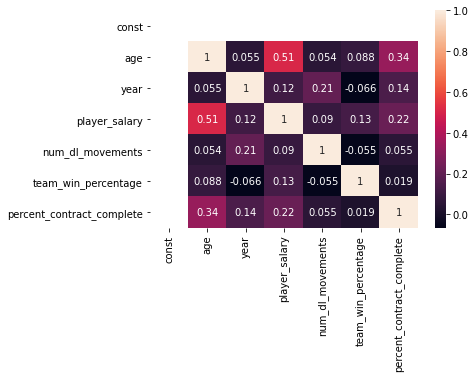

In [38]:
corrMatrix = X_new.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [40]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_new,y,test_size=0.2)


In [42]:
print("shape of original dataset :", X_new.shape)
print("shape of input - training set", X_train.shape)
print("shape of output - training set", y_train.shape)
print("shape of input - testing set", X_test.shape)
print("shape of output - testing set", y_test.shape)

shape of original dataset : (2385, 7)
shape of input - training set (1908, 7)
shape of output - training set (1908, 1)
shape of input - testing set (477, 7)
shape of output - testing set (477, 1)


NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

0.13130147833529537

AttributeError: 'RandomOverSampler' object has no attribute 'fit_sample'